In [11]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [12]:
backtest_start_date = datetime(2001,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [13]:
market = Market()

In [14]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
# portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
#                           ,classifier_list.WEEKLY_CRYPTO_FASTSLOW_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)
# portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
#                           ,classifier_list.WEEKLY_CRYPTO_FASTSLOW_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)
# portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
#                           ,classifier_list.WEEKLY_CRYPTO_SPECULATION_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
# portfolios.append(portfolio_iv)
# portfolios.append(portfolio_v)
# portfolios.append(portfolio_vi)

In [15]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [16]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [17]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [18]:
bench_returns

,year,week,adjclose,quarter,day,bench_weekly_return,quarter_start,bench_quarterly_return,weekly_variance,quarterly_variance
14,1928,15,19.0375,2.0,1.5,0.000815,19.0375,0.000000,0.001176,0.000943
15,1928,16,19.3900,2.0,2.0,0.018516,19.0375,0.018516,0.000789,0.000933
16,1928,17,19.5380,2.0,2.0,0.007633,19.0375,0.026290,0.000211,0.000929
17,1928,18,19.3760,2.0,2.0,-0.008292,19.0375,0.017781,0.000215,0.000890
18,1928,19,19.9060,2.0,2.0,0.027353,19.0375,0.045620,0.000237,0.000943
...,...,...,...,...,...,...,...,...,...,...
4977,2023,22,4162.0400,2.0,4.0,0.000731,4105.1300,0.013863,0.000164,0.000248
4978,2023,23,4222.1900,2.0,4.0,0.014452,4105.1300,0.028516,0.000092,0.000224
4979,2023,24,4283.5900,2.0,4.0,0.014542,4105.1300,0.043472,0.000097,0.000247
4980,2023,25,4383.1900,2.0,4.0,0.023252,4105.1300,0.067735,0.000107,0.000420


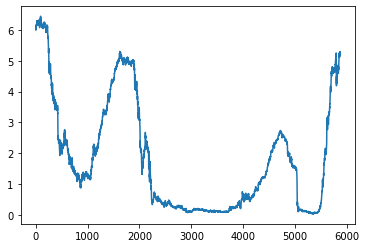

In [19]:
plt.plot(tyields["value"])

In [68]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("trades")
    trade["positions"] = int(portfolio.pricer_class.positions / 5)
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [69]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [70]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,...,classification,rank,short,market_return,buy_day,sell_day,risk,positions,portfolio,pricer_timeframe
0,2003,5,ABMD,0.131069,1.0,0.984283,0.952849,0,0.952849,True,...,False,False,False,1.15,1,5,True,20,wss_n_n_b_r,week
1,2003,6,ROL,0.174102,1.0,0.973770,0.990150,0,0.990150,True,...,False,False,False,1.15,1,5,True,20,wss_n_n_b_r,week
2,2003,7,BKNG,0.082569,1.0,1.024000,0.984000,0,0.984000,True,...,False,False,False,1.15,1,5,True,20,wss_n_n_b_r,week
3,2003,8,NFLX,0.101533,1.0,0.957708,0.999318,0,0.999318,True,...,False,False,False,1.15,1,5,True,20,wss_n_n_b_r,week
4,2003,9,ROL,0.098497,1.0,1.001595,1.005743,0,1.005743,True,...,False,False,False,1.15,1,5,True,20,wss_n_n_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90006,2023,16,NVR,0.027352,1.0,1.023565,0.987113,99,0.987113,True,...,False,False,False,1.15,1,5,True,20,wsw_n_n_b_r,week
90007,2023,17,JCI,0.022972,1.0,1.022470,1.027273,99,1.027273,True,...,False,False,False,1.15,1,5,True,20,wsw_n_n_b_r,week
90008,2023,18,IPGP,0.020639,1.0,0.972512,0.941766,99,0.941766,True,...,False,False,False,1.15,1,5,True,20,wsw_n_n_b_r,week
90009,2023,19,PYPL,0.024364,1.0,0.944541,0.922540,99,0.922540,True,...,False,False,False,1.15,1,5,True,20,wsw_n_n_b_r,week


In [71]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [72]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [73]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'portfolio',
 'pricer_timeframe']

In [74]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


In [75]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
955,True,True,False,False,False,1.15,1,5,True,wss_n_n_b_r,week,14.464499,-0.066325,0.777753,-202.992939
1069,True,True,False,False,False,1.15,1,5,True,wsr_n_n_b_r,week,12.344939,0.096042,1.203895,118.114819
1068,True,True,False,False,False,1.15,1,5,True,wsw_n_n_b_r,week,7.407097,0.232820,1.492866,27.515236


In [76]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_n_n_b_r,True,True,False,False,False,1.15,1,5,True,week,12.344939,0.096042,1.203895,118.114819
1,wss_n_n_b_r,True,True,False,False,False,1.15,1,5,True,week,14.464499,-0.066325,0.777753,-202.992939
2,wsw_n_n_b_r,True,True,False,False,False,1.15,1,5,True,week,7.407097,0.232820,1.492866,27.515236


In [107]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

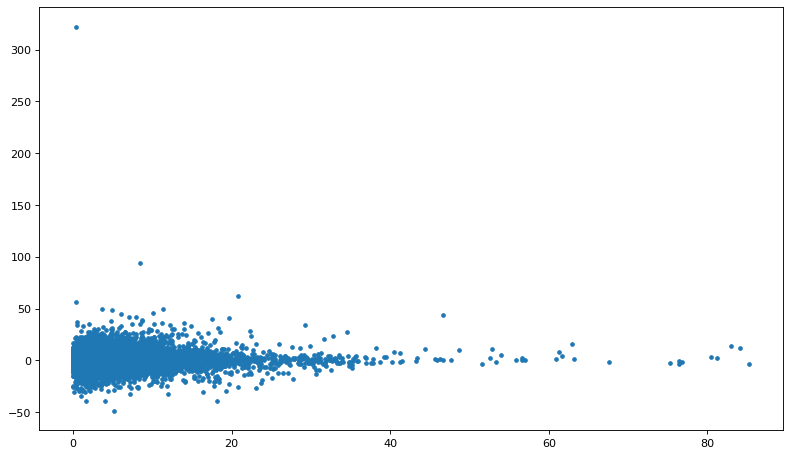

In [108]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [109]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2003,5,ABMD,0.131069,1.0,0.952849,0,Health Care,Abiomed
956,2003,5,BDX,0.043588,1.0,0.951671,1,Health Care,Becton Dickinson
1910,2003,5,PTC,0.039568,1.0,0.945833,2,Information Technology,PTC
2864,2003,5,FCX,0.018587,1.0,1.012273,3,Materials,Freeport-McMoRan
3815,2003,5,RMD,0.014746,1.0,1.023411,4,Health Care,ResMed
4764,2003,5,J,0.011867,1.0,1.005442,5,Industrials,Jacobs Engineering Group
5713,2003,5,IDXX,0.004632,1.0,1.008605,6,Health Care,Idexx Laboratories
6661,2003,5,NEM,0.003383,1.0,1.011202,7,Materials,Newmont
7605,2003,5,WYNN,0.003218,1.0,0.952314,8,Consumer Discretionary,Wynn Resorts
8546,2003,5,NFLX,0.002539,1.0,0.980080,9,Communication Services,Netflix


In [110]:
ledger["actual_returns"].mean()

1.0025782461610746

In [111]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5396631013952762

In [112]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [113]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,2003,5,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2003,6,0.990150,0.942857,1.121875,0.984262,0.899696,0.963834,1.048838,0.975148,...,0.946496,0.988535,0.931796,0.951932,1.016198,0.981054,0.948816,0.936444,0.969726,0.971961
2,2003,7,0.984000,1.021645,1.037932,1.058158,1.035787,1.036345,0.990301,1.013508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,2003,8,0.999318,0.997179,0.989375,1.033672,1.021512,1.034378,1.000000,1.083006,...,0.989233,0.926684,1.014272,1.017488,0.968786,0.983444,0.995169,1.022669,1.002179,0.988248
4,2003,9,1.005743,1.041590,0.977533,1.009594,1.005620,0.993576,0.969620,0.979890,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,2022,48,1.009232,1.012409,1.029450,1.023712,0.989544,1.063769,1.000496,0.869617,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
952,2022,49,1.028257,1.029321,1.004483,1.040735,1.015401,0.958065,1.025269,0.974743,...,1.074247,1.000972,1.068379,0.974762,1.028903,1.005275,1.006218,1.039613,0.993026,0.929546
953,2022,50,0.980036,0.892789,0.855728,0.911981,0.890051,0.955278,0.958933,0.908487,...,0.949812,1.010928,0.901437,0.931593,0.949093,0.937100,0.931917,1.001288,1.000000,1.000000
954,2022,51,1.020191,1.001369,1.027878,1.002240,1.000478,0.992464,1.009530,1.013091,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [115]:
cumulative.head(50)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,0.952314,0.980080,...,1.000000,1.000000,1.000000,2003,5,0.992184,878.680008,1.000000,2003-W5,2003-01-31
1,0.943463,0.897289,1.061107,0.996342,0.920759,0.969079,1.057864,0.986071,0.928278,0.821334,...,0.968007,0.985642,0.970210,2003,6,0.965586,854.137988,0.972069,2003-W6,2003-02-07
2,0.928368,0.916711,1.101357,1.054288,0.953710,1.004300,1.047603,0.999391,0.948282,0.808389,...,0.954507,0.967451,0.996888,2003,7,0.972693,843.990014,0.960520,2003-W7,2003-02-14
3,0.927734,0.914125,1.089655,1.089788,0.974227,1.038826,1.047603,1.082347,0.975463,0.822589,...,0.981717,0.988636,0.982491,2003,8,0.975150,827.221997,0.941437,2003-W8,2003-02-21
4,0.933063,0.952144,1.065174,1.100244,0.979701,1.032153,1.015778,1.060581,0.947648,0.823809,...,0.894498,1.058108,0.981060,2003,9,0.970637,845.392487,0.962116,2003-W9,2003-02-28
5,0.910269,0.902644,1.080724,1.133542,0.957397,0.986032,0.974920,1.054638,0.933597,0.778769,...,0.928288,1.152958,0.894678,2003,10,0.948870,835.426013,0.950774,2003-W10,2003-03-07
6,1.029151,1.023141,1.338512,1.244161,1.050161,1.192781,1.028284,1.108581,1.091975,0.788293,...,1.046804,1.191268,0.932448,2003,11,1.042336,827.527991,0.941785,2003-W11,2003-03-14
7,1.453676,1.027726,1.114137,1.225729,1.054551,1.224589,0.986597,1.126788,1.086537,0.778595,...,1.087927,1.192518,0.911762,2003,12,1.053421,815.514001,0.928113,2003-W12,2003-03-21
8,1.584835,1.026209,1.200148,1.291797,1.053178,1.291760,0.969788,1.137345,1.113200,0.747822,...,1.119282,1.139339,0.890317,2003,13,1.065373,874.943994,0.995748,2003-W13,2003-03-28
9,1.686813,1.128830,1.209436,1.345250,1.029811,1.302644,0.951175,1.101830,1.113200,0.745010,...,1.124217,1.147988,0.899201,2003,14,1.092971,868.188000,0.988059,2003-W14,2003-04-04


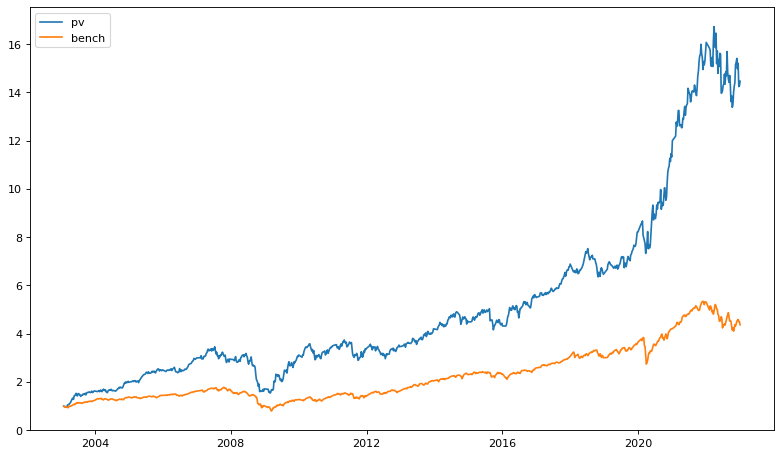

In [116]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [117]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,0.952314,0.980080,...,1.000000,1.000000,1.000000,2003,5,0.992184,878.680008,1.000000,2003-W5,2003-01-31
1,0.943463,0.897289,1.061107,0.996342,0.920759,0.969079,1.057864,0.986071,0.928278,0.821334,...,0.968007,0.985642,0.970210,2003,6,0.965586,854.137988,0.972069,2003-W6,2003-02-07
2,0.928368,0.916711,1.101357,1.054288,0.953710,1.004300,1.047603,0.999391,0.948282,0.808389,...,0.954507,0.967451,0.996888,2003,7,0.972693,843.990014,0.960520,2003-W7,2003-02-14
3,0.927734,0.914125,1.089655,1.089788,0.974227,1.038826,1.047603,1.082347,0.975463,0.822589,...,0.981717,0.988636,0.982491,2003,8,0.975150,827.221997,0.941437,2003-W8,2003-02-21
4,0.933063,0.952144,1.065174,1.100244,0.979701,1.032153,1.015778,1.060581,0.947648,0.823809,...,0.894498,1.058108,0.981060,2003,9,0.970637,845.392487,0.962116,2003-W9,2003-02-28
5,0.910269,0.902644,1.080724,1.133542,0.957397,0.986032,0.974920,1.054638,0.933597,0.778769,...,0.928288,1.152958,0.894678,2003,10,0.948870,835.426013,0.950774,2003-W10,2003-03-07
6,1.029151,1.023141,1.338512,1.244161,1.050161,1.192781,1.028284,1.108581,1.091975,0.788293,...,1.046804,1.191268,0.932448,2003,11,1.042336,827.527991,0.941785,2003-W11,2003-03-14
7,1.453676,1.027726,1.114137,1.225729,1.054551,1.224589,0.986597,1.126788,1.086537,0.778595,...,1.087927,1.192518,0.911762,2003,12,1.053421,815.514001,0.928113,2003-W12,2003-03-21
8,1.584835,1.026209,1.200148,1.291797,1.053178,1.291760,0.969788,1.137345,1.113200,0.747822,...,1.119282,1.139339,0.890317,2003,13,1.065373,874.943994,0.995748,2003-W13,2003-03-28
9,1.686813,1.128830,1.209436,1.345250,1.029811,1.302644,0.951175,1.101830,1.113200,0.745010,...,1.124217,1.147988,0.899201,2003,14,1.092971,868.188000,0.988059,2003-W14,2003-04-04


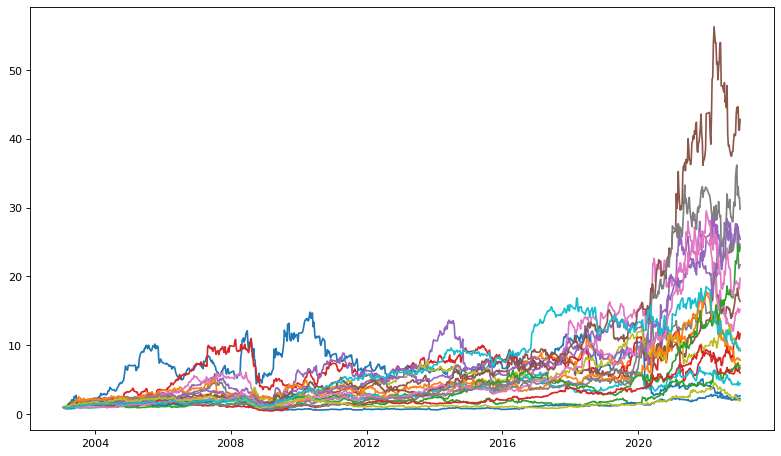

In [118]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [119]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Communication Services,2013.469586,28.628345,0.030563,1.0,1.003163,40.614659
Materials,2012.519943,28.201576,0.027451,1.0,1.003146,46.064724
Real Estate,2012.073494,27.959896,0.025167,1.0,1.003022,47.094385
Industrials,2012.412768,28.451660,0.026772,1.0,1.002877,47.800679
Energy,2012.661241,27.769576,0.031774,1.0,1.002796,39.922818
Information Technology,2013.362237,28.637947,0.031245,1.0,1.002778,43.042941
Consumer Discretionary,2012.687657,28.620347,0.040735,1.0,1.002723,38.429219
Health Care,2012.539709,28.952083,0.026976,1.0,1.002435,43.934332
Financials,2012.335103,28.796545,0.026539,1.0,1.002053,47.856801


In [120]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,weekly_delta,weekly_delta_sign,actual_returns,position
year,week,ticker,Security,,,,
2007,26,JCI,Johnson Controls,0.004092,1.0,4.221513,25
2008,42,UAL,United Airlines Holdings,0.083907,1.0,1.935484,30
2009,18,LVS,Las Vegas Sands,0.208342,1.0,1.624642,2
2020,5,TSLA,"Tesla, Inc.",0.003217,1.0,1.564756,17
2003,20,REGN,Regeneron,0.036379,1.0,1.500000,72
2013,19,TSLA,"Tesla, Inc.",0.113933,1.0,1.499550,1
2006,39,ALGN,Align Technology,0.049290,1.0,1.483660,8
2009,18,CBRE,CBRE Group,0.100423,1.0,1.455128,17
2020,7,ENPH,Enphase,0.060833,1.0,1.442763,2


In [121]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2003,5,0.980080,0.952314,1.000000,1.000000,1.000000,0.984134,1.005442,0.945833,1.011737,1.000000,1.000000
1,4012009,30,0.938524,0.925293,0.962803,0.995124,0.971937,0.980189,0.986373,0.951137,0.993073,0.980583,0.945143
2,8036054027,210,1.094703,0.919608,0.971920,0.968951,0.996076,0.971351,0.999122,0.987605,1.010165,0.995404,0.956431
3,16096216216081,1680,1.086413,0.917510,0.947319,0.991597,0.988083,0.975589,0.978708,0.984639,0.998320,1.000366,0.970563
4,32240721080810243,15120,1.120859,0.896412,0.932726,1.002740,0.987984,0.976330,0.968161,0.978314,0.972834,1.011106,0.949389
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,17.852304,11.091261,16.089816,6.830842,6.399182,10.711352,16.946699,13.838197,11.947462,9.768229,3.949798
952,0,0,18.520880,11.249807,16.357395,6.830842,6.412025,11.054081,16.943779,14.454548,12.197298,9.792199,4.039647
953,0,0,16.553631,10.509942,16.044141,6.830842,6.054674,10.490101,15.995477,13.308641,12.197298,9.262869,3.898060
954,0,0,16.684298,10.565794,16.044141,6.830842,6.139838,10.686309,16.003123,13.208341,12.197298,9.262869,3.898060
